In [6]:
# เริ่มต้นใช้งาน GEE
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar

ee.Authenticate()
try:
    ee.Initialize(project="ee-sakda-451407")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="ee-sakda-451407")

In [ ]:
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar

# กำหนดพื้นที่ศึกษาที่ใหญ่ขึ้น - ครอบคลุมภาคเหนือ
STUDY_AREA = ee.Geometry.Polygon(
    [[[98.0, 18.0],
      [100.0, 18.0],
      [100.0, 20.0],
      [98.0, 20.0],
      [98.0, 18.0]]])  # ขยายเป็น 2° x 2° ≈ 220x220 km

# ฟังก์ชันคำนวณ NDVI จาก MOD09Q1
def calculate_ndvi(image):
    try:
        # MOD09Q1 bands: sur_refl_b01 (red), sur_refl_b02 (NIR)
        nir = image.select('sur_refl_b02').multiply(0.0001)  # Apply scale factor
        red = image.select('sur_refl_b01').multiply(0.0001)  # Apply scale factor
        
        # คำนวณ NDVI
        ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
        
        # กำหนดคุณสมบัติให้กับภาพ
        return image.addBands(ndvi).copyProperties(image, ['system:time_start'])
    except Exception as e:
        print(f"Error calculating NDVI: {e}")
        return None

# ฟังก์ชันดึงข้อมูล NDVI รายเดือนจาก MOD09Q1
def get_monthly_ndvi(start_date, end_date, study_area):
    try:
        # เรียกชุดข้อมูล MOD09Q1
        modis = ee.ImageCollection('MODIS/061/MOD09Q1') \
            .filterDate(start_date, end_date) \
            .filterBounds(study_area)
        
        # ตรวจสอบว่ามีข้อมูลหรือไม่
        size = modis.size().getInfo()
        print(f"จำนวนภาพ MODIS ดิบ: {size}")
        if size == 0:
            print("ไม่มีข้อมูล MOD09Q1 ในพื้นที่ศึกษา")
            return None
        
        # คำนวณ NDVI
        modis_ndvi = modis.map(calculate_ndvi)
        print(f"จำนวนภาพหลังคำนวณ NDVI: {modis_ndvi.size().getInfo()}")
        
        # เฉลี่ย NDVI เป็นรายเดือน
        def create_monthly_composite(year_month):
            year = ee.Number(year_month).divide(100).floor().int()
            month = ee.Number(year_month).mod(100).int()
            
            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')
            
            monthly_collection = modis_ndvi.filterDate(start, end)
            count = monthly_collection.size()
            
            # สร้างภาพเฉลี่ยรายเดือน
            monthly_mean = monthly_collection.mean() \
                .set('system:time_start', start.millis()) \
                .set('system:index', start.format('YYYY_MM')) \
                .set('year', year) \
                .set('month', month)
            
            return ee.Algorithms.If(
                count.gt(0), 
                monthly_mean,
                ee.Image.constant(0).rename('NDVI') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month)
            )
        
        # สร้างรายการปี-เดือน
        start_year = int(start_date.split('-')[0])
        end_year = int(end_date.split('-')[0])
        year_months = []
        
        for year in range(start_year, end_year + 1):
            start_month = 1 if year > start_year else int(start_date.split('-')[1])
            end_month = 12 if year < end_year else int(end_date.split('-')[1])
            
            for month in range(start_month, end_month + 1):
                year_months.append(year * 100 + month)
        
        year_months_ee = ee.List(year_months)
        
        # สร้าง ImageCollection
        monthly_images = year_months_ee.map(create_monthly_composite)
        monthly_composites = ee.ImageCollection.fromImages(monthly_images)
        
        print(f"จำนวนเดือนทั้งหมด: {monthly_composites.size().getInfo()}")
        
        return monthly_composites.select('NDVI')
    except Exception as e:
        print(f"Error getting monthly NDVI: {e}")
        return None

# ฟังก์ชันสร้างข้อมูลรวมรายเดือน - Modified to focus on hotspot count
def create_monthly_dataset(ndvi_collection, study_area):
    try:
        # ตรวจสอบว่ามีข้อมูลหรือไม่
        if ndvi_collection is None:
            print("ข้อมูล NDVI เป็น None")
            return None
            
        ndvi_size = ndvi_collection.size().getInfo()
        print(f"NDVI collection size: {ndvi_size}")
        
        if ndvi_size == 0:
            print("ไม่มีข้อมูล NDVI")
            return None
        
        # ใช้วันที่ของ NDVI เป็นหลัก
        ndvi_times = ndvi_collection.aggregate_array('system:time_start')
        print(f"จำนวนเดือนที่มีข้อมูล NDVI: {ndvi_times.size().getInfo()}")
        
        # ฟังก์ชันสำหรับรวมข้อมูลแต่ละเดือน - Modified for hotspot count
        def combine_monthly_data(time_start):
            # กรองข้อมูล NDVI ตามเวลา
            ndvi_image = ndvi_collection.filter(ee.Filter.eq('system:time_start', time_start)).first()
            
            # หา hotspot ในเดือนเดียวกับ NDVI
            start_date = ee.Date(time_start)
            end_date = start_date.advance(1, 'month')
            
            # ดึงข้อมูล FIRMS ในช่วงเวลาเดียวกับ NDVI
            firms_in_period = ee.ImageCollection('FIRMS') \
                .filterDate(start_date, end_date) \
                .filterBounds(study_area) \
                .select(['T21', 'confidence'])
            
            # คำนวณจำนวน hotspot และค่าเฉลี่ย T21
            hotspot_count = firms_in_period.size()
            mean_t21 = firms_in_period.mean().select('T21')
            mean_confidence = firms_in_period.mean().select('confidence')
            
            # สร้างภาพที่มี hotspot count, mean T21, และ confidence
            hotspot_count_image = ee.Image.constant(hotspot_count).rename('hotspot_count')
            
            # กำหนดค่าเริ่มต้นสำหรับ T21 และ confidence ถ้าไม่มีข้อมูล
            mean_t21_filled = ee.Algorithms.If(
                hotspot_count.gt(0),
                mean_t21,
                ee.Image.constant(0).rename('T21')
            )
            
            mean_confidence_filled = ee.Algorithms.If(
                hotspot_count.gt(0),
                mean_confidence,
                ee.Image.constant(0).rename('confidence')
            )
            
            # รวมภาพ
            combined_image = ndvi_image \
                .addBands(hotspot_count_image) \
                .addBands(ee.Image(mean_t21_filled)) \
                .addBands(ee.Image(mean_confidence_filled))
            
            # ลดขนาดข้อมูลเป็นค่าเฉลี่ยของพื้นที่ศึกษา
            reduced = combined_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=study_area,
                scale=1000,  # 1km resolution
                maxPixels=1e9
            )
            
            # สร้าง Feature พร้อมวันที่
            date_str = ee.Date(time_start).format('YYYY-MM-dd')
            year = ee.Date(time_start).get('year')
            month = ee.Date(time_start).get('month')
            
            # Create properties dictionary properly
            properties = reduced.combine({
                'date': date_str,
                'year': year,
                'month': month
            })
            
            return ee.Feature(None, properties)
        
        # แปลงเป็น FeatureCollection โดยใช้เวลาของ NDVI
        if ndvi_times.size().getInfo() > 0:
            combined_fc = ee.FeatureCollection(ndvi_times.map(combine_monthly_data))
            return combined_fc
        else:
            print("ไม่มีข้อมูล NDVI")
            return None
            
    except Exception as e:
        print(f"Error creating monthly dataset: {e}")
        return None

# ฟังก์ชันแปลง FeatureCollection เป็น DataFrame
def fc_to_df(fc):
    try:
        # ดึงข้อมูลจาก GEE
        features = fc.getInfo()['features']
    except Exception as e:
        print("ไม่สามารถดึงข้อมูลจาก GEE ได้:", str(e))
        return pd.DataFrame()
    
    # สร้าง dictionary สำหรับเก็บข้อมูล - Modified for hotspot count focus
    data_dict = {'date': [], 'NDVI': [], 'hotspot_count': [], 'T21': [], 'confidence': [], 'year': [], 'month': []}
    
    for feature in features:
        props = feature['properties']
        if 'NDVI' in props and props['NDVI'] is not None:
            data_dict['date'].append(props.get('date', ''))
            data_dict['NDVI'].append(props.get('NDVI', 0))
            data_dict['hotspot_count'].append(props.get('hotspot_count', 0))
            data_dict['T21'].append(props.get('T21', 0))
            data_dict['confidence'].append(props.get('confidence', 0))
            data_dict['year'].append(props.get('year', 0))
            data_dict['month'].append(props.get('month', 0))
    
    # สร้าง DataFrame
    df = pd.DataFrame(data_dict)
    
    # แปลงคอลัมน์ date เป็น datetime
    if not df.empty:
        df['date'] = pd.to_datetime(df['date'])
        df.sort_values('date', inplace=True)
    
    return df

# ฟังก์ชันเพิ่ม seasonal features
def add_seasonal_features(df):
    """เพิ่ม features สำหรับฤดูกาล"""
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # ฤดูแล้ง (มีค.ค. - พ.ค.) และฤดูฝน (มิ.ย. - ต.ค.)
    df['dry_season'] = ((df['month'] >= 11) | (df['month'] <= 5)).astype(int)
    df['wet_season'] = ((df['month'] >= 6) & (df['month'] <= 10)).astype(int)
    
    return df

# ฟังก์ชันเตรียมข้อมูลสำหรับการฝึกแบบจำลองรายเดือน - Modified for hotspot count
def prepare_monthly_training_data(df, sequence_length=6, target_column='hotspot_count'):
    # ตรวจสอบว่ามีข้อมูลหรือไม่
    if df.empty:
        raise ValueError("ไม่มีข้อมูลใน DataFrame")
    
    print(f"จำนวนข้อมูลดิบ: {len(df)}")
    print(f"คอลัมน์ที่มี: {df.columns.tolist()}")
    print(f"ตัวอย่างข้อมูล:\n{df.head()}")
    
    # เพิ่ม seasonal features
    df = add_seasonal_features(df)
    
    # ล้างข้อมูลที่ขาดหาย
    df_cleaned = df.fillna(0)
    print(f"จำนวนข้อมูลหลังล้าง: {len(df_cleaned)}")
    print(f"ค่าสถิติพื้นฐาน:\n{df_cleaned.describe()}")
    
    # ตรวจสอบว่ามีข้อมูลเพียงพอหลังจากล้างข้อมูล
    min_required = sequence_length + 5
    if len(df_cleaned) < min_required:
        raise ValueError(f"ข้อมูลไม่เพียงพอสำหรับการสร้างลำดับ ต้องการอย่างน้อย {min_required} ข้อมูล แต่มีเพียง {len(df_cleaned)}")
    
    # เตรียมข้อมูล feature และ target - Modified for hotspot count prediction
    feature_columns = ['NDVI', 'T21', 'confidence', 'month_sin', 'month_cos', 'dry_season', 'wet_season']
    
    # ตรวจสอบว่า target column มีอยู่
    if target_column not in df_cleaned.columns:
        target_column = 'hotspot_count'
        print(f"ใช้ {target_column} เป็น target variable")
    
    X = df_cleaned[feature_columns].values
    y = df_cleaned[[target_column]].values
    
    print(f"Features ที่ใช้: {feature_columns}")
    print(f"Target ที่ใช้: {target_column}")
    
    # ปรับขนาดข้อมูล
    from sklearn.preprocessing import StandardScaler
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    # สร้างลำดับข้อมูลสำหรับ LSTM
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i+sequence_length])
        y_seq.append(y_scaled[i+sequence_length])
    
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    
    print(f"จำนวนลำดับที่สร้างได้: {len(X_seq)}")
    print(f"รูปร่างข้อมูล X: {X_seq.shape}, y: {y_seq.shape}")
    
    return X_seq, y_seq, scaler_x, scaler_y, df_cleaned

# ฟังก์ชันสร้างแบบจำลอง LSTM สำหรับรายเดือน
def create_monthly_lstm_model(sequence_length, n_features):
    """สร้างแบบจำลอง LSTM สำหรับทำนาย hotspot count รายเดือน"""
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.regularizers import l2
        
        model = Sequential()
        
        # LSTM layers with regularization
        model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, n_features),
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())
        
        model.add(LSTM(64, return_sequences=True,
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())
        
        model.add(LSTM(32, return_sequences=False,
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
        
        # Dense layers
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.2))
        
        # Output layer - using ReLU to ensure non-negative counts
        model.add(Dense(1, activation='relu'))
        
        model.compile(optimizer=Adam(learning_rate=0.001), 
                      loss='mse', 
                      metrics=['mae'])
        
        return model
    except ImportError:
        print("ไม่สามารถ import TensorFlow ได้ กรุณาติดตั้ง TensorFlow ก่อน")
        return None
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างแบบจำลอง: {e}")
        return None

# NEW: ฟังก์ชันสร้าง Learning Curve Chart
def plot_learning_curves(history):
    """แสดงกราฟ learning curves"""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        plt.style.use('default')
        sns.set_palette("husl")
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss curve
        axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
        if 'val_loss' in history.history:
            axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
        axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss (MSE)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # MAE curve
        axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2, color='green')
        if 'val_mae' in history.history:
            axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='orange')
        axes[1].set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Mean Absolute Error')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("บันทึกกราฟ Learning Curves: learning_curves.png")
        
    except ImportError:
        print("ไม่สามารถ import matplotlib หรือ seaborn ได้")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟ Learning Curves: {e}")

# NEW: ฟังก์ชันสร้าง Actual vs Predicted Chart
def plot_actual_vs_predicted(y_true, y_pred, title="Actual vs Predicted Hotspot Count"):
    """แสดงกราฟ actual vs predicted"""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.metrics import r2_score
        
        plt.style.use('default')
        sns.set_palette("husl")
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Scatter plot
        axes[0].scatter(y_true, y_pred, alpha=0.7, color='blue', s=50)
        
        # Perfect prediction line
        min_val = min(min(y_true), min(y_pred))
        max_val = max(max(y_true), max(y_pred))
        axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        
        # Calculate R²
        r2 = r2_score(y_true, y_pred)
        axes[0].set_title(f'{title}\nR² = {r2:.4f}', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Actual Hotspot Count')
        axes[0].set_ylabel('Predicted Hotspot Count')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Residual plot
        residuals = y_pred - y_true
        axes[1].scatter(y_pred, residuals, alpha=0.7, color='green', s=50)
        axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
        axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Predicted Hotspot Count')
        axes[1].set_ylabel('Residuals (Predicted - Actual)')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("บันทึกกราฟ Actual vs Predicted: actual_vs_predicted.png")
        
    except ImportError:
        print("ไม่สามารถ import matplotlib หรือ seaborn ได้")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟ Actual vs Predicted: {e}")

# ฟังก์ชันทำนาย 12 เดือนข้างหน้า - Modified for hotspot count
def predict_next_12_months(model, last_sequence, scaler_x, scaler_y, df_cleaned, sequence_length=6):
    """ทำนายค่า hotspot count สำหรับ 12 เดือนถัดไป"""
    
    predictions = []
    prediction_dates = []
    current_sequence = last_sequence.copy()
    
    # หาวันที่สุดท้ายในข้อมูล
    last_date = df_cleaned['date'].iloc[-1]
    
    for month_ahead in range(1, 13):  # ทำนาย 12 เดือนข้างหน้า
        # ทำนายเดือนถัดไป
        pred_scaled = model.predict(current_sequence, verbose=0)
        pred_original = scaler_y.inverse_transform(pred_scaled)
        # Ensure non-negative count
        pred_count = max(0, int(round(pred_original[0][0])))
        predictions.append(pred_count)
        
        # คำนวณวันที่ของเดือนถัดไป
        if last_date.month == 12:
            next_year = last_date.year + (last_date.month + month_ahead - 1) // 12
            next_month = ((last_date.month + month_ahead - 1) % 12) + 1
        else:
            next_year = last_date.year + (last_date.month + month_ahead - 1) // 12
            next_month = ((last_date.month + month_ahead - 1) % 12) + 1
        
        # สร้างวันที่ที่ถูกต้อง
        if next_month > 12:
            next_year += 1
            next_month = next_month - 12
            
        prediction_date = datetime(next_year, next_month, 1)
        prediction_dates.append(prediction_date)
        
        # สร้าง features สำหรับเดือนถัดไป
        month_sin = np.sin(2 * np.pi * next_month / 12)
        month_cos = np.cos(2 * np.pi * next_month / 12)
        dry_season = 1 if (next_month >= 11 or next_month <= 5) else 0
        wet_season = 1 if (6 <= next_month <= 10) else 0
        
        # สมมติค่า NDVI, T21, confidence (ใช้ค่าเฉลี่ยจากข้อมูลเดือนเดียวกันในอดีต)
        same_month_data = df_cleaned[df_cleaned['month'] == next_month]
        if not same_month_data.empty:
            avg_ndvi = same_month_data['NDVI'].mean()
            avg_t21 = same_month_data['T21'].mean()
            avg_confidence = same_month_data['confidence'].mean()
        else:
            avg_ndvi = df_cleaned['NDVI'].mean()
            avg_t21 = df_cleaned['T21'].mean()
            avg_confidence = df_cleaned['confidence'].mean()
        
        # สร้าง feature vector สำหรับเดือนถัดไป
        next_features = np.array([[avg_ndvi, avg_t21, avg_confidence, month_sin, month_cos, dry_season, wet_season]])
        
        # ปรับขนาดข้อมูล
        next_features_scaled = scaler_x.transform(next_features)
        
        # อัพเดท sequence สำหรับการทำนายครั้งถัดไป
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1] = next_features_scaled[0]
    
    return predictions, prediction_dates

# ฟังก์ชันสร้างกราฟทำนาย 12 เดือน - Modified for hotspot count
def plot_12_month_prediction(df, predictions, prediction_dates, target_column='hotspot_count'):
    """แสดงกราฟข้อมูลจริงและการทำนาย 12 เดือน"""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # ใช้ style ที่สวยงาม
        plt.style.use('default')
        sns.set_palette("husl")
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
        
        # กราฟที่ 1: ข้อมูลทั้งหมด + การทำนาย
        # แสดงข้อมูลจริงย้อนหลัง 24 เดือน
        recent_data = df.tail(24)
        ax1.plot(recent_data['date'], recent_data[target_column], 
                label=f'Historical {target_column}', color='blue', marker='o', markersize=4, linewidth=2)
        
        # แสดงข้อมูล 6 เดือนล่าสุดที่ใช้ทำนาย
        last_6_months = df.tail(6)
        ax1.plot(last_6_months['date'], last_6_months[target_column], 
                label=f'Last 6 months (prediction input)', 
                color='orange', marker='s', markersize=6, linewidth=3)
        
        # แสดงการทำนาย 12 เดือน
        ax1.plot(prediction_dates, predictions, 
                label=f'12-month predictions', color='red', marker='*', markersize=8, linewidth=3)
        
        # เชื่อมเส้นจากข้อมูลล่าสุดไปยังการทำนาย
        ax1.plot([df['date'].iloc[-1], prediction_dates[0]], 
                [df[target_column].iloc[-1], predictions[0]], 
                '--', color='red', alpha=0.7, linewidth=2)
        
        ax1.set_title(f'{target_column} - 12-Month Ahead Predictions', fontsize=16, fontweight='bold')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel(f'{target_column} Count', fontsize=12)
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        
        # กราฟที่ 2: Seasonal Pattern
        months = [date.month for date in prediction_dates]
        month_names = [calendar.month_name[month][:3] for month in months]
        
        # Define risk levels for hotspot count
        high_threshold = df[target_column].quantile(0.8)
        medium_threshold = df[target_column].quantile(0.6)
        
        colors = ['red' if pred > high_threshold else 
                 'orange' if pred > medium_threshold else 'green' 
                 for pred in predictions]
        
        bars = ax2.bar(month_names, predictions, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
        ax2.set_title('Monthly Hotspot Count Predictions by Season (Next 12 Months)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Month', fontsize=12)
        ax2.set_ylabel(f'Predicted {target_column}', fontsize=12)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # เพิ่มค่าบนแท่งกราฟ
        for bar, pred in zip(bars, predictions):
            height = bar.get_height()
            ax2.annotate(f'{pred}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # เพิ่ม legend สำหรับสี
        import matplotlib.patches as mpatches
        high_patch = mpatches.Patch(color='red', alpha=0.7, label=f'High Risk (>{high_threshold:.0f})')
        medium_patch = mpatches.Patch(color='orange', alpha=0.7, label=f'Medium Risk ({medium_threshold:.0f}-{high_threshold:.0f})')
        low_patch = mpatches.Patch(color='green', alpha=0.7, label=f'Low Risk (<{medium_threshold:.0f})')
        ax2.legend(handles=[high_patch, medium_patch, low_patch], loc='upper right')
        
        plt.tight_layout()
        plt.savefig('12_month_hotspot_count_prediction.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("บันทึกกราฟทำนาย 12 เดือน: 12_month_hotspot_count_prediction.png")
        
    except ImportError:
        print("ไม่สามารถ import matplotlib หรือ seaborn ได้")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟทำนาย 12 เดือน: {e}")

# ฟังก์ชันสร้างตารางสรุปการทำนาย 12 เดือน - Modified for hotspot count
def create_prediction_summary_table(predictions, prediction_dates, target_column='hotspot_count'):
    """สร้างตารางสรุปการทำนาย hotspot count"""
    try:
        # สร้าง DataFrame สำหรับการทำนาย
        pred_df = pd.DataFrame({
            'Date': prediction_dates,
            'Month': [calendar.month_name[date.month] for date in prediction_dates],
            'Year': [date.year for date in prediction_dates],
            f'Predicted_{target_column}': predictions
        })
        
        # เพิ่มคอลัมน์ Risk Level สำหรับ hotspot count
        def get_risk_level(count):
            if count > 100:  # High hotspot count
                return 'Very High Risk'
            elif count > 50:
                return 'High Risk'
            elif count > 20:
                return 'Medium Risk'
            elif count > 5:
                return 'Low Risk'
            else:
                return 'Very Low Risk'
        
        pred_df['Risk_Level'] = pred_df[f'Predicted_{target_column}'].apply(get_risk_level)
        
        # เพิ่มคอลัมน์ฤดู
        def get_season(month):
            if month in ['December', 'January', 'February', 'March', 'April', 'May']:
                return 'Dry Season'
            else:
                return 'Wet Season'
        
        pred_df['Season'] = pred_df['Month'].apply(get_season)
        
        print("\n" + "="*80)
        print("สรุปการทำนาย HOTSPOT COUNT รายเดือนสำหรับ 12 เดือนข้างหน้า")
        print("="*80)
        print(pred_df.to_string(index=False))
        
        # สถิติสรุป
        print("\n" + "="*50)
        print("สถิติสรุป")
        print("="*50)
        print(f"ค่าเฉลี่ย: {pred_df[f'Predicted_{target_column}'].mean():.1f} hotspots")
        print(f"ค่าสูงสุด: {pred_df[f'Predicted_{target_column}'].max()} hotspots ({pred_df.loc[pred_df[f'Predicted_{target_column}'].idxmax(), 'Month']})")
        print(f"ค่าต่ำสุด: {pred_df[f'Predicted_{target_column}'].min()} hotspots ({pred_df.loc[pred_df[f'Predicted_{target_column}'].idxmin(), 'Month']})")
        print(f"รวมทั้งปี: {pred_df[f'Predicted_{target_column}'].sum()} hotspots")
        
        # สรุปตามระดับความเสี่ยง
        risk_summary = pred_df['Risk_Level'].value_counts()
        print(f"\nสรุปตามระดับความเสี่ยง:")
        for risk, count in risk_summary.items():
            print(f"  {risk}: {count} เดือน ({count/12*100:.1f}%)")
        
        # สรุปตามฤดู
        season_summary = pred_df.groupby('Season')[f'Predicted_{target_column}'].agg(['mean', 'max', 'min', 'sum'])
        print(f"\nสรุปตามฤดู:")
        for season in season_summary.index:
            print(f"  {season}:")
            print(f"    ค่าเฉลี่ย: {season_summary.loc[season, 'mean']:.1f} hotspots/month")
            print(f"    ค่าสูงสุด: {season_summary.loc[season, 'max']} hotspots")
            print(f"    ค่าต่ำสุด: {season_summary.loc[season, 'min']} hotspots")
            print(f"    รวม: {season_summary.loc[season, 'sum']} hotspots")
        
        # บันทึกตารางเป็นไฟล์ CSV
        pred_df.to_csv('12_month_hotspot_count_predictions.csv', index=False)
        print(f"\nบันทึกตารางการทำนาย: 12_month_hotspot_count_predictions.csv")
        
        return pred_df
        
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างตารางสรุป: {e}")
        return None

# ฟังก์ชันสร้างแผนที่ Folium สำหรับการทำนาย 12 เดือน - Modified for hotspot count
def create_12_month_prediction_map(predictions, prediction_dates, study_area, target_column='hotspot_count'):
    """สร้างแผนที่ Folium แสดงการทำนาย hotspot count 12 เดือน"""
    try:
        import folium
        from folium import plugins
        import branca.colormap as cm
        
        # สร้างแผนที่หลัก
        map_center = study_area.centroid().coordinates().getInfo()[::-1]
        m = folium.Map(
            location=map_center, 
            zoom_start=9,
            tiles='OpenStreetMap'
        )
        
        # เพิ่ม layer พื้นที่ศึกษา
        study_area_geo = study_area.getInfo()
        folium.GeoJson(
            study_area_geo,
            name='Study Area',
            style_function=lambda x: {
                'fillColor': 'lightblue', 
                'color': 'blue', 
                'weight': 2, 
                'fillOpacity': 0.2,
                'dashArray': '5, 5'
            },
            tooltip='Study Area - Northern Thailand'
        ).add_to(m)
        
        # สร้าง colormap สำหรับค่าทำนาย
        min_pred = min(predictions)
        max_pred = max(predictions)
        colormap = cm.linear.Reds.scale(min_pred, max_pred)
        
        # เพิ่ม markers สำหรับแต่ละเดือน
        for i, (pred, date) in enumerate(zip(predictions, prediction_dates)):
            # กำหนดตำแหน่งสำหรับแต่ละเดือน (กระจายรอบจุดกลาง)
            import math
            angle = (2 * math.pi * i) / 12  # กระจายเป็นวงกลม
            offset = 0.05  # ระยะห่างจากจุดกลาง
            lat_offset = offset * math.cos(angle)
            lon_offset = offset * math.sin(angle)
            
            marker_location = [map_center[0] + lat_offset, map_center[1] + lon_offset]
            
            # กำหนดสีและระดับความเสี่ยง สำหรับ hotspot count
            if pred > 100:
                risk_level = 'Very High Risk'
                icon_color = 'darkred'
                icon = 'fire'
            elif pred > 50:
                risk_level = 'High Risk'
                icon_color = 'red'
                icon = 'fire'
            elif pred > 20:
                risk_level = 'Medium Risk'
                icon_color = 'orange'
                icon = 'exclamation-triangle'
            elif pred > 5:
                risk_level = 'Low Risk'
                icon_color = 'yellow'
                icon = 'info-sign'
            else:
                risk_level = 'Very Low Risk'
                icon_color = 'green'
                icon = 'ok-sign'
            
            # สร้าง popup content
            popup_content = f"""
            <div style="font-family: Arial; font-size: 12px; width: 200px;">
                <h4 style="margin: 5px 0; color: {icon_color};">
                    {calendar.month_name[date.month]} {date.year}
                </h4>
                <b>Predicted Hotspot Count:</b> {pred}<br>
                <b>Risk Level:</b> <span style="color: {icon_color}; font-weight: bold;">{risk_level}</span><br>
                <b>Season:</b> {'Dry Season' if date.month in [12, 1, 2, 3, 4, 5] else 'Wet Season'}
            </div>
            """
            
            # เพิ่ม marker
            folium.Marker(
                location=marker_location,
                popup=folium.Popup(popup_content, max_width=250),
                tooltip=f'{calendar.month_name[date.month]}: {pred} hotspots ({risk_level})',
                icon=folium.Icon(
                    color=icon_color,
                    icon=icon,
                    prefix='fa'
                )
            ).add_to(m)
            
            # เพิ่ม circle แสดงขนาดจำนวน hotspot
            radius = max(100, pred * 20)  # Scale radius based on hotspot count
            folium.Circle(
                location=marker_location,
                radius=radius,
                popup=f'{calendar.month_name[date.month]}: {pred} hotspots',
                color=colormap(pred),
                fillColor=colormap(pred),
                fillOpacity=0.4,
                weight=2
            ).add_to(m)
        
        # เพิ่ม legend สำหรับระดับความเสี่ยง
        legend_html = f'''
        <div style="position: fixed; 
                    bottom: 50px; left: 50px; width: 250px; height: 180px; 
                    background-color: white; border:2px solid grey; z-index:9999; 
                    font-size:12px; padding: 10px; border-radius: 5px;">
        <h4>Hotspot Count Risk Levels (12-Month Forecast)</h4>
        <div><span style="color: darkred;">●</span> Very High Risk (&gt;100)</div>
        <div><span style="color: red;">●</span> High Risk (51-100)</div>
        <div><span style="color: orange;">●</span> Medium Risk (21-50)</div>
        <div><span style="color: yellow;">●</span> Low Risk (6-20)</div>
        <div><span style="color: green;">●</span> Very Low Risk (≤5)</div>
        <hr style="margin: 10px 0;">
        <b>Statistics:</b><br>
        <small>Average: {np.mean(predictions):.1f} hotspots</small><br>
        <small>Max: {max(predictions)} hotspots</small><br>
        <small>Total Year: {sum(predictions)} hotspots</small>
        </div>
        '''
        m.get_root().html.add_child(folium.Element(legend_html))
        
        # เพิ่มข้อมูลช่วงเวลาการทำนาย
        time_info_html = f'''
        <div style="position: fixed; 
                    top: 10px; right: 10px; width: 250px; height: 80px; 
                    background-color: rgba(255,255,255,0.9); border:1px solid grey; 
                    z-index:9999; font-size:12px; padding: 8px; border-radius: 5px;">
        <b>Prediction Period:</b><br>
        {calendar.month_name[prediction_dates[0].month]} {prediction_dates[0].year} - 
        {calendar.month_name[prediction_dates[-1].month]} {prediction_dates[-1].year}<br>
        <small>12-month hotspot count forecast</small><br>
        <small>Target: {target_column}</small>
        </div>
        '''
        m.get_root().html.add_child(folium.Element(time_info_html))
        
        # เพิ่ม colormap แสดงสเกลสี
        colormap.add_to(m)
        
        # เพิ่ม plugins
        plugins.Fullscreen().add_to(m)
        plugins.MeasureControl().add_to(m)
        folium.LayerControl().add_to(m)
        
        return m
        
    except ImportError:
        print("ไม่สามารถ import folium ได้ กรุณาติดตั้ง folium")
        return None
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างแผนที่ 12 เดือน: {e}")
        return None

# ฟังก์ชันประเมินผลแบบจำลอง - Enhanced for hotspot count
def evaluate_model(y_true, y_pred):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # Calculate MAPE if no zero values in y_true
    try:
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        print(f'MAPE: {mape:.2f}%')
    except:
        mape = None
        print('MAPE: Cannot calculate (zero values present)')
    
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R²: {r2:.4f}')
    
    # Additional metrics for count data
    print(f'Mean Actual: {np.mean(y_true):.2f}')
    print(f'Mean Predicted: {np.mean(y_pred):.2f}')
    print(f'Std Actual: {np.std(y_true):.2f}')
    print(f'Std Predicted: {np.std(y_pred):.2f}')
    
    return mse, rmse, mae, r2

# รันโค้ดหลักสำหรับการทำนายรายเดือน - Modified for hotspot count
def main():
    print("เริ่มการวิเคราะห์และทำนาย HOTSPOT COUNT รายเดือนสำหรับ 12 เดือนข้างหน้า")
    print("="*80)
    
    # กำหนดช่วงเวลาข้อมูล (เพิ่มข้อมูลให้มากขึ้น)
    start_date = '2018-01-01'
    end_date = '2024-08-01'

    print("กำลังดึงข้อมูล NDVI รายเดือนจาก Google Earth Engine...")
    ndvi_data = get_monthly_ndvi(start_date, end_date, STUDY_AREA)

    if ndvi_data is None:
        print("ไม่สามารถดึงข้อมูล NDVI ได้ กำลังขยายพื้นที่ศึกษา...")
        # ขยายพื้นที่ศึกษา
        STUDY_AREA_EXPANDED = ee.Geometry.Polygon(
            [[[97.5, 17.5],
              [100.5, 17.5],
              [100.5, 20.5],
              [97.5, 20.5],
              [97.5, 17.5]]])
        print("ขยายพื้นที่ศึกษา...")
        ndvi_data = get_monthly_ndvi(start_date, end_date, STUDY_AREA_EXPANDED)
        study_area = STUDY_AREA_EXPANDED
    else:
        study_area = STUDY_AREA

    if ndvi_data is not None:
        print(f"จำนวนเดือนที่มีข้อมูล NDVI: {ndvi_data.size().getInfo()}")
        
        print("กำลังสร้างชุดข้อมูลรวม...")
        dataset = create_monthly_dataset(ndvi_data, study_area)

        if dataset is not None:
            print("กำลังแปลงข้อมูลเป็น DataFrame...")
            df = fc_to_df(dataset)
            print(f"จำนวนข้อมูลใน DataFrame: {len(df)} เดือน")

            if not df.empty and len(df) > 12:  # ต้องมีข้อมูลอย่างน้อย 12 เดือน
                print("ตัวอย่างข้อมูล:")
                print(df.head(10))
                print(f"\nช่วงข้อมูล: {df['date'].min()} ถึง {df['date'].max()}")
                print(f"สถิติ Hotspot Count: min={df['hotspot_count'].min()}, max={df['hotspot_count'].max()}, mean={df['hotspot_count'].mean():.2f}")
                
                print("กำลังเตรียมข้อมูลสำหรับการฝึกแบบจำลอง...")
                try:
                    X, y, scaler_x, scaler_y, df_cleaned = prepare_monthly_training_data(
                        df, sequence_length=6, target_column='hotspot_count'
                    )
                    print(f"ข้อมูลที่เตรียม: X.shape = {X.shape}, y.shape = {y.shape}")
                    
                    # แบ่งข้อมูลฝึกและทดสอบ
                    split_idx = int(len(X) * 0.8)
                    X_train, X_test = X[:split_idx], X[split_idx:]
                    y_train, y_test = y[:split_idx], y[split_idx:]

                    print(f"ข้อมูลฝึก: {X_train.shape}, ข้อมูลทดสอบ: {X_test.shape}")

                    # สร้างและฝึกแบบจำลอง
                    print("กำลังสร้างแบบจำลอง LSTM สำหรับ Hotspot Count...")
                    model = create_monthly_lstm_model(X_train.shape[1], X_train.shape[2])
                    
                    if model is None:
                        print("ไม่สามารถสร้างแบบจำลองได้ กรุณาตรวจสอบการติดตั้ง TensorFlow")
                        return

                    print("กำลังฝึกแบบจำลอง...")
                    
                    # เพิ่ม callbacks สำหรับการฝึกที่ดีขึ้น
                    try:
                        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
                        
                        early_stopping = EarlyStopping(
                            monitor='val_loss', 
                            patience=15, 
                            restore_best_weights=True,
                            verbose=1
                        )
                        
                        reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss', 
                            factor=0.5, 
                            patience=10, 
                            min_lr=1e-7,
                            verbose=1
                        )
                        
                        callbacks = [early_stopping, reduce_lr]
                    except ImportError:
                        callbacks = []
                    
                    history = model.fit(
                        X_train, y_train,
                        epochs=100,  # เพิ่ม epochs
                        batch_size=16,
                        validation_data=(X_test, y_test) if len(X_test) > 0 else None,
                        callbacks=callbacks,
                        verbose=1
                    )

                    # NEW: Plot learning curves
                    print("\nกำลังสร้างกราฟ Learning Curves...")
                    plot_learning_curves(history)

                    # ประเมินแบบจำลอง
                    if len(X_test) > 0:
                        print("\nกำลังประเมินแบบจำลอง...")
                        y_pred = model.predict(X_test)
                        y_pred_rescaled = scaler_y.inverse_transform(y_pred)
                        y_test_rescaled = scaler_y.inverse_transform(y_test)

                        print("ผลการประเมินแบบจำลอง:")
                        mse, rmse, mae, r2 = evaluate_model(y_test_rescaled, y_pred_rescaled)
                        
                        # NEW: Plot actual vs predicted
                        print("\nกำลังสร้างกราฟ Actual vs Predicted...")
                        plot_actual_vs_predicted(
                            y_test_rescaled.flatten(), 
                            y_pred_rescaled.flatten(), 
                            "Actual vs Predicted Hotspot Count"
                        )

                    # ทำนาย 12 เดือนข้างหน้า
                    print("\nกำลังทำนาย 12 เดือนข้างหน้า...")
                    last_sequence = X[-1:]
                    predictions, prediction_dates = predict_next_12_months(
                        model, last_sequence, scaler_x, scaler_y, df_cleaned, sequence_length=6
                    )

                    print("การทำนายเสร็จสมบูรณ์!")
                    print(f"การทำนาย 12 เดือน: {predictions}")
                    
                    # สร้างตารางสรุป
                    print("\nกำลังสร้างตารางสรุปการทำนาย...")
                    pred_summary_df = create_prediction_summary_table(
                        predictions, prediction_dates, target_column='hotspot_count'
                    )

                    # สร้างกราฟต่างๆ
                    print("\nกำลังสร้างกราฟการทำนาย 12 เดือน...")
                    plot_12_month_prediction(df_cleaned, predictions, prediction_dates, target_column='hotspot_count')

                    # สร้างแผนที่
                    print("กำลังสร้างแผนที่การทำนาย 12 เดือน...")
                    try:
                        prediction_map = create_12_month_prediction_map(
                            predictions, prediction_dates, study_area, target_column='hotspot_count'
                        )
                        if prediction_map is not None:
                            # บันทึกแผนที่
                            prediction_map.save('12_month_hotspot_count_prediction_map.html')
                            print("บันทึกแผนที่เรียบร้อยแล้ว: 12_month_hotspot_count_prediction_map.html")
                                
                        else:
                            print("ไม่สามารถสร้างแผนที่ได้")
                    except Exception as map_error:
                        print(f"ไม่สามารถสร้างแผนที่ได้: {map_error}")

                    print("\nการวิเคราะห์และทำนาย HOTSPOT COUNT รายเดือนเสร็จสมบูรณ์!")
                    print("\nไฟล์ที่สร้าง:")
                    print("1. learning_curves.png - กราฟการเรียนรู้ของแบบจำลอง")
                    print("2. actual_vs_predicted.png - กราฟเปรียบเทียบค่าจริงกับค่าทำนาย")
                    print("3. 12_month_hotspot_count_prediction.png - กราฟการทำนาย 12 เดือน")
                    print("4. 12_month_hotspot_count_predictions.csv - ตารางการทำนาย")
                    print("5. 12_month_hotspot_count_prediction_map.html - แผนที่การทำนาย")

                except Exception as e:
                    print(f"เกิดข้อผิดพลาดในการเตรียมข้อมูล: {e}")
                    import traceback
                    print("รายละเอียดข้อผิดพลาด:")
                    traceback.print_exc()
            else:
                print("ข้อมูลไม่เพียงพอสำหรับการสร้างแบบจำลอง (ต้องการอย่างน้อย 12 เดือน)")
        else:
            print("ไม่สามารถสร้างชุดข้อมูลได้")
    else:
        print("ไม่สามารถดึงข้อมูล NDVI ได้")

# เรียกใช้ฟังก์ชันหลัก
if __name__ == "__main__":
    # Initialize Earth Engine (ต้องทำการ authenticate ก่อน)
    try:
        print("กำลังเชื่อมต่อ Google Earth Engine...")
        # ee.Authenticate()  # ถ้ายังไม่ได้ authenticate
        ee.Authenticate()
        try:
            ee.Initialize(project="ee-sakda-451407")
        except Exception as e:
            ee.Authenticate()
            ee.Initialize(project="ee-sakda-451407")
        print("เชื่อมต่อ Google Earth Engine สำเร็จ")
        
        main()
        
    except Exception as e:
        print(f"ไม่สามารถเชื่อมต่อ Google Earth Engine ได้: {e}")
        print("กรุณาตรวจสอบ:")
        print("   1. การติดตั้ง earthengine-api")
        print("   2. การ authenticate: ee.Authenticate()")
        print("   3. การเชื่อมต่ออินเทอร์เน็ต")

กำลังเชื่อมต่อ Google Earth Engine...
เชื่อมต่อ Google Earth Engine สำเร็จ
เริ่มการวิเคราะห์และทำนาย HOTSPOT COUNT รายเดือนสำหรับ 12 เดือนข้างหน้า
กำลังดึงข้อมูล NDVI รายเดือนจาก Google Earth Engine...
จำนวนภาพ MODIS ดิบ: 303
จำนวนภาพหลังคำนวณ NDVI: 303
จำนวนเดือนทั้งหมด: 80
จำนวนเดือนที่มีข้อมูล NDVI: 80
กำลังสร้างชุดข้อมูลรวม...
NDVI collection size: 80
จำนวนเดือนที่มีข้อมูล NDVI: 80
กำลังแปลงข้อมูลเป็น DataFrame...
จำนวนข้อมูลใน DataFrame: 80 เดือน
ตัวอย่างข้อมูล:
        date      NDVI  hotspot_count  year  month
0 2018-01-01  0.646911     629.164706  2018      1
1 2018-02-01  0.644496    2726.125490  2018      2
2 2018-03-01  0.589554    4359.333333  2018      3
3 2018-04-01  0.615040    2660.466667  2018      4
4 2018-05-01  0.602343     190.070588  2018      5
5 2018-06-01  0.388867       0.000000  2018      6
6 2018-07-01  0.281510      11.000000  2018      7
7 2018-08-01  0.299895       0.000000  2018      8
8 2018-09-01  0.584422      58.752941  2018      9
9 2018-10-01  0.68

/Users/sakdahomhuan/miniforge3/envs/udfire/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


กำลังฝึกแบบจำลอง...
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 1.4814 - mae: 0.7642 - val_loss: 1.0527 - val_mae: 0.7141 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1383 - mae: 0.6378 - val_loss: 1.0331 - val_mae: 0.7027 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0185 - mae: 0.6179 - val_loss: 1.0059 - val_mae: 0.6900 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7996 - mae: 0.5000 - val_loss: 0.9785 - val_mae: 0.6767 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7519 - mae: 0.4517 - val_loss: 0.9494 - val_mae: 0.6609 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6866 - mae: 0.5102 - val_loss: 0.9234 - val_mae: 0.6452 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7968 - mae: 0.5412 - val_loss: 0.9149 - val_mae: 0.6382 - learning_rate: 0.0010

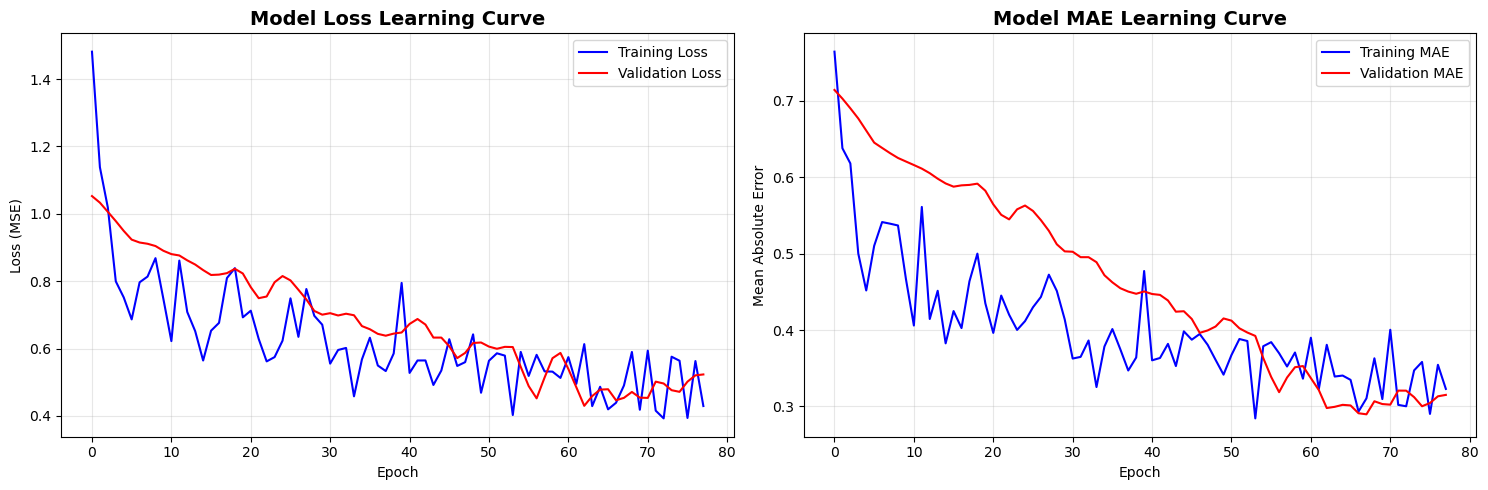

บันทึกกราฟ Learning Curve: learning_curve.png

กำลังประเมินแบบจำลอง...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
ผลการประเมินแบบจำลอง:
MSE: 1846312.3113
RMSE: 1358.7908
MAE: 903.6585
R²: 0.7497

กำลังสร้างกราฟ Actual vs Predicted...


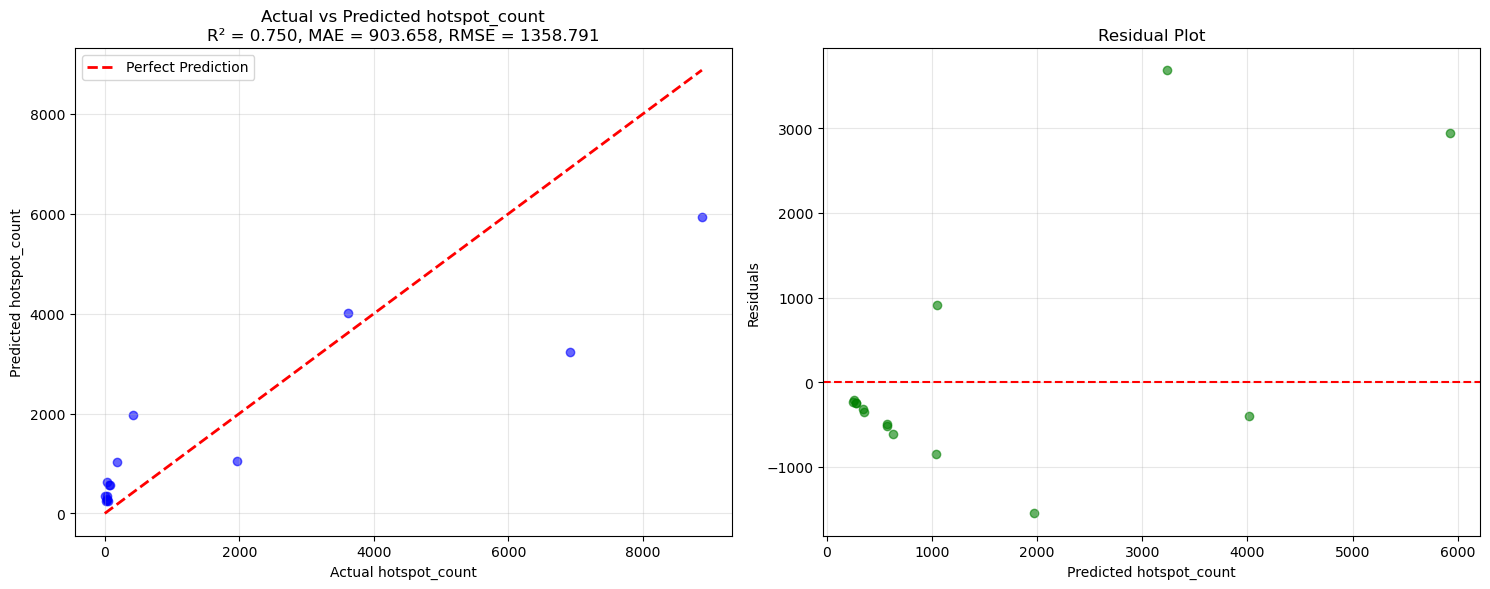

บันทึกกราฟ Actual vs Predicted: actual_vs_predicted.png

กำลังทำนาย 12 เดือนข้างหน้า...
การทำนายเสร็จสมบูรณ์!

กำลังสร้างตารางสรุปการทำนาย...

สรุปการทำนาย HOTSPOT COUNT รายเดือนสำหรับ 12 เดือนข้างหน้า
      Date     Month  Year  Predicted_hotspot_count Risk_Level     Season
2024-09-01 September  2024                    256.0  High Risk Wet Season
2024-10-01   October  2024                    270.0  High Risk Wet Season
2024-11-01  November  2024                    289.0  High Risk Wet Season
2024-12-01  December  2024                    701.0  High Risk Dry Season
2025-01-01   January  2025                   1388.0  High Risk Dry Season
2025-02-01  February  2025                   3515.0  High Risk Dry Season
2025-03-01     March  2025                   7756.0  High Risk Dry Season
2025-04-01     April  2025                   4846.0  High Risk Dry Season
2025-05-01       May  2025                    964.0  High Risk Dry Season
2025-06-01      June  2025                    578.0  High 

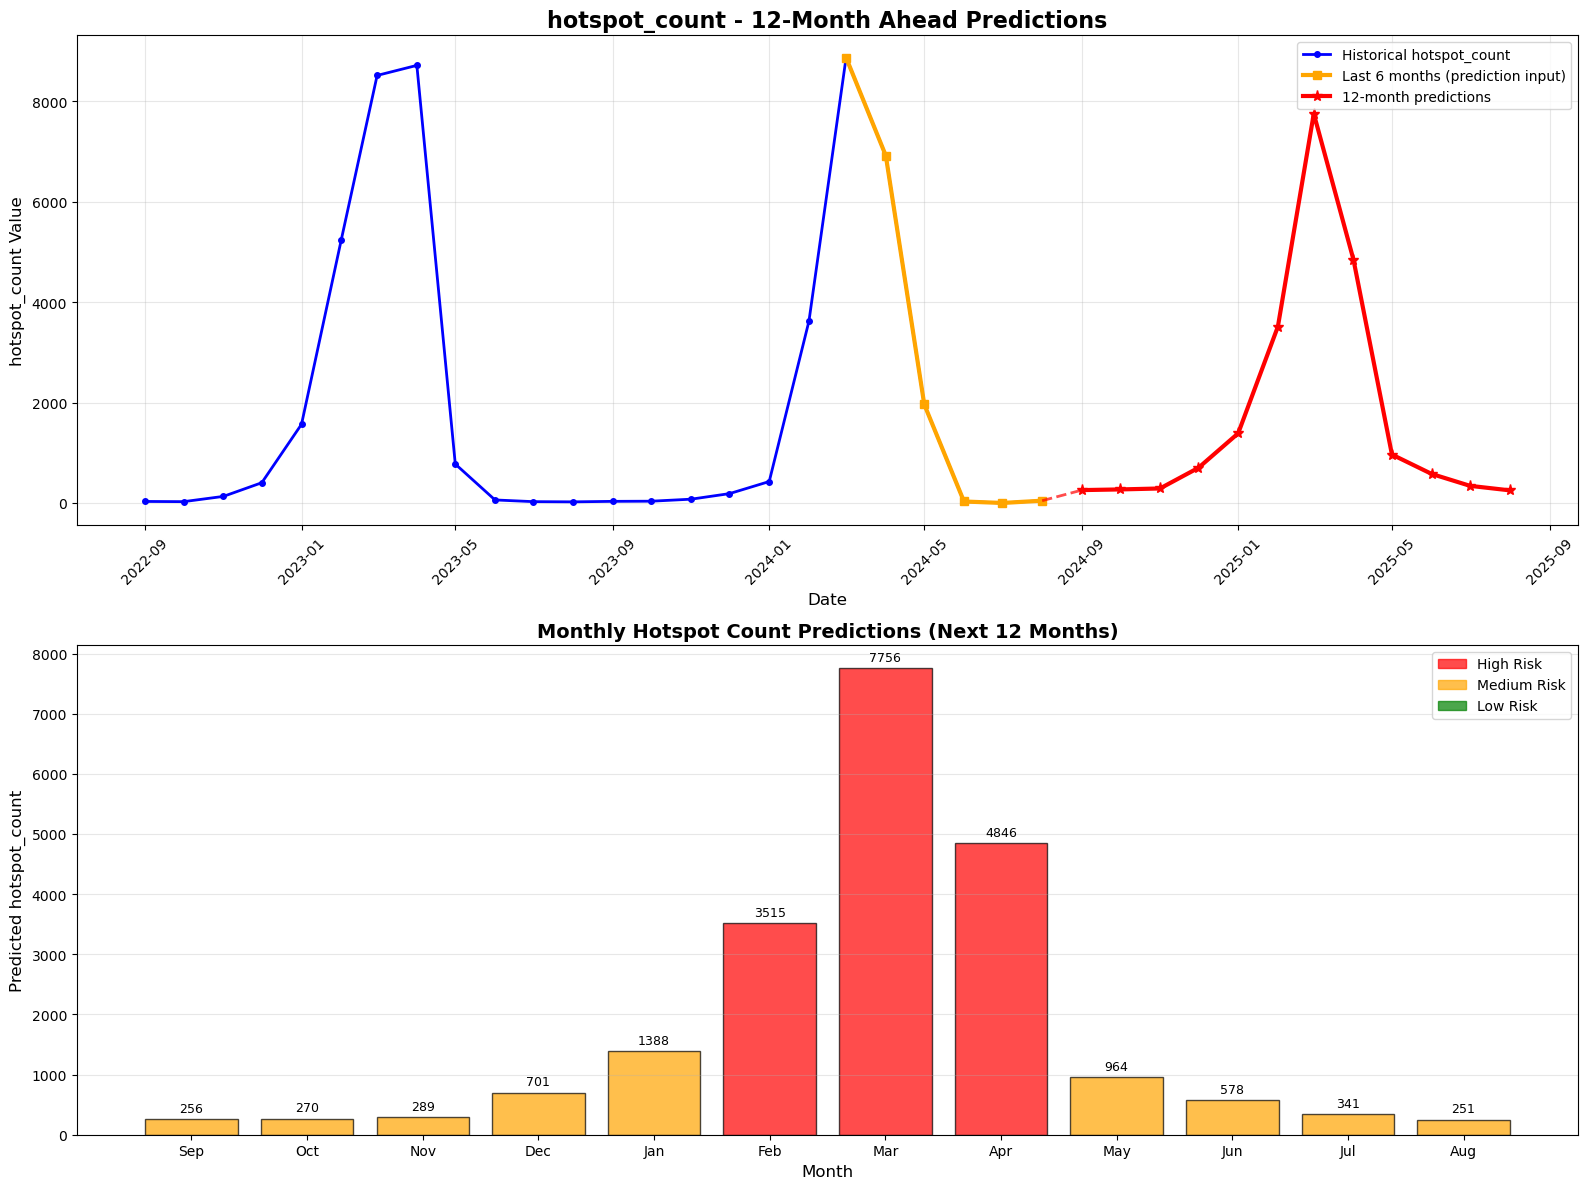

บันทึกกราฟทำนาย 12 เดือน: 12_month_prediction.png

การวิเคราะห์และทำนาย HOTSPOT COUNT รายเดือนเสร็จสมบูรณ์!
ไฟล์ที่สร้าง:
  - learning_curve.png: กราฟ Learning Curve
  - actual_vs_predicted.png: กราฟ Actual vs Predicted
  - 12_month_prediction.png: กราฟการทำนาย 12 เดือน
  - 12_month_hotspot_predictions.csv: ตารางผลการทำนาย


In [24]:
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar

# กำหนดพื้นที่ศึกษาที่ใหญ่ขึ้น - ครอบคลุมภาคเหนือ
STUDY_AREA = ee.Geometry.Polygon(
    [[[98.0, 18.0],
      [100.0, 18.0],
      [100.0, 20.0],
      [98.0, 20.0],
      [98.0, 18.0]]])  # ขยายเป็น 2° x 2° ≈ 220x220 km

# ฟังก์ชันคำนวณ NDVI จาก MOD09Q1
def calculate_ndvi(image):
    try:
        # MOD09Q1 bands: sur_refl_b01 (red), sur_refl_b02 (NIR)
        nir = image.select('sur_refl_b02').multiply(0.0001)  # Apply scale factor
        red = image.select('sur_refl_b01').multiply(0.0001)  # Apply scale factor
        
        # คำนวณ NDVI
        ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
        
        # กำหนดคุณสมบัติให้กับภาพ
        return image.addBands(ndvi).copyProperties(image, ['system:time_start'])
    except Exception as e:
        print(f"Error calculating NDVI: {e}")
        return None

# ฟังก์ชันดึงข้อมูล NDVI รายเดือนจาก MOD09Q1
def get_monthly_ndvi(start_date, end_date, study_area):
    try:
        # เรียกชุดข้อมูล MOD09Q1
        modis = ee.ImageCollection('MODIS/061/MOD09Q1') \
            .filterDate(start_date, end_date) \
            .filterBounds(study_area)
        
        # ตรวจสอบว่ามีข้อมูลหรือไม่
        size = modis.size().getInfo()
        print(f"จำนวนภาพ MODIS ดิบ: {size}")
        if size == 0:
            print("ไม่มีข้อมูล MOD09Q1 ในพื้นที่ศึกษา")
            return None
        
        # คำนวณ NDVI
        modis_ndvi = modis.map(calculate_ndvi)
        print(f"จำนวนภาพหลังคำนวณ NDVI: {modis_ndvi.size().getInfo()}")
        
        # เฉลี่ย NDVI เป็นรายเดือน
        def create_monthly_composite(year_month):
            year = ee.Number(year_month).divide(100).floor().int()
            month = ee.Number(year_month).mod(100).int()
            
            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')
            
            monthly_collection = modis_ndvi.filterDate(start, end)
            count = monthly_collection.size()
            
            # สร้างภาพเฉลี่ยรายเดือน
            monthly_mean = monthly_collection.mean() \
                .set('system:time_start', start.millis()) \
                .set('system:index', start.format('YYYY_MM')) \
                .set('year', year) \
                .set('month', month)
            
            return ee.Algorithms.If(
                count.gt(0), 
                monthly_mean,
                ee.Image.constant(0).rename('NDVI') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month)
            )
        
        # สร้างรายการปี-เดือน
        start_year = int(start_date.split('-')[0])
        end_year = int(end_date.split('-')[0])
        year_months = []
        
        for year in range(start_year, end_year + 1):
            start_month = 1 if year > start_year else int(start_date.split('-')[1])
            end_month = 12 if year < end_year else int(end_date.split('-')[1])
            
            for month in range(start_month, end_month + 1):
                year_months.append(year * 100 + month)
        
        year_months_ee = ee.List(year_months)
        
        # สร้าง ImageCollection
        monthly_images = year_months_ee.map(create_monthly_composite)
        monthly_composites = ee.ImageCollection.fromImages(monthly_images)
        
        print(f"จำนวนเดือนทั้งหมด: {monthly_composites.size().getInfo()}")
        
        return monthly_composites.select('NDVI')
    except Exception as e:
        print(f"Error getting monthly NDVI: {e}")
        return None

# ฟังก์ชันดึงข้อมูล Hotspot รายเดือนจาก FIRMS - MODIFIED VERSION
def get_monthly_hotspots(start_date, end_date, study_area):
    try:
        # เรียกชุดข้อมูล FIRMS
        firms = ee.ImageCollection('FIRMS') \
            .filterDate(start_date, end_date) \
            .filterBounds(study_area)
        
        # ตรวจสอบว่ามีข้อมูลหรือไม่
        size = firms.size().getInfo()
        print(f"จำนวนภาพ FIRMS ดิบ: {size}")
        if size == 0:
            print("ไม่มีข้อมูล FIRMS ในพื้นที่ศึกษา")
            return None
        
        # 1. Assign T21 value to 1 for each layer (convert to hotspot presence/absence)
        def convert_to_presence(image):
            # Create binary hotspot mask where T21 > 0 (presence of hotspot)
            hotspot_presence = image.select('T21').gt(0).rename('hotspot_presence')
            return image.addBands(hotspot_presence).copyProperties(image, ['system:time_start'])
        
        firms_with_presence = firms.map(convert_to_presence)
        
        # รวม hotspot เป็นรายเดือนใหม่
        def create_monthly_hotspot_composite(year_month):
            year = ee.Number(year_month).divide(100).floor().int()
            month = ee.Number(year_month).mod(100).int()
            
            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')
            
            monthly_collection = firms_with_presence.filterDate(start, end)
            count = monthly_collection.size()
            
            # 2. Use spatial reduce to sum new value for study area
            # 3. Sum hotspot for month with time series reduce
            if count.getInfo() > 0:
                # Sum hotspot presence across time for the month
                monthly_sum = monthly_collection.select('hotspot_presence').sum()
                
                # Reduce spatially to get total hotspot count for the study area
                hotspot_count = monthly_sum.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=study_area,
                    scale=1000,
                    maxPixels=1e9
                ).get('hotspot_presence')
                
                # Create an image with the hotspot count
                hotspot_count_image = ee.Image.constant(hotspot_count).rename('hotspot_count') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month)
                
                return hotspot_count_image
            else:
                # No hotspots in this month
                return ee.Image.constant(0).rename('hotspot_count') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month)
        
        # สร้างรายการปี-เดือน
        start_year = int(start_date.split('-')[0])
        end_year = int(end_date.split('-')[0])
        year_months = []
        
        for year in range(start_year, end_year + 1):
            start_month = 1 if year > start_year else int(start_date.split('-')[1])
            end_month = 12 if year < end_year else int(end_date.split('-')[1])
            
            for month in range(start_month, end_month + 1):
                year_months.append(year * 100 + month)
        
        year_months_ee = ee.List(year_months)
        
        # สร้าง ImageCollection
        monthly_images = year_months_ee.map(create_monthly_hotspot_composite)
        monthly_composites = ee.ImageCollection.fromImages(monthly_images)
        
        print(f"จำนวนเดือนที่มี hotspot: {monthly_composites.size().getInfo()}")
        
        return monthly_composites.select(['hotspot_count'])
    except Exception as e:
        print(f"Error getting monthly hotspots: {e}")
        return None

# ฟังก์ชันสร้างข้อมูลรวมรายเดือน - FIXED VERSION
def create_monthly_dataset(ndvi_collection, study_area):
    try:
        # ตรวจสอบว่ามีข้อมูลหรือไม่
        if ndvi_collection is None:
            print("ข้อมูล NDVI เป็น None")
            return None
            
        ndvi_size = ndvi_collection.size().getInfo()
        print(f"NDVI collection size: {ndvi_size}")
        
        if ndvi_size == 0:
            print("ไม่มีข้อมูล NDVI")
            return None
        
        # ใช้วันที่ของ NDVI เป็นหลัก
        ndvi_times = ndvi_collection.aggregate_array('system:time_start')
        print(f"จำนวนเดือนที่มีข้อมูล NDVI: {ndvi_times.size().getInfo()}")
        
        # ฟังก์ชันสำหรับรวมข้อมูลแต่ละเดือน - FIXED to avoid client-side operations
        def combine_monthly_data(time_start):
            # กรองข้อมูล NDVI ตามเวลา
            ndvi_image = ndvi_collection.filter(ee.Filter.eq('system:time_start', time_start)).first()
            
            # หา hotspot ในเดือนเดียวกับ NDVI
            start_date = ee.Date(time_start)
            end_date = start_date.advance(1, 'month')
            
            # ดึงข้อมูล FIRMS ในช่วงเวลาเดียวกับ NDVI
            firms_in_period = ee.ImageCollection('FIRMS') \
                .filterDate(start_date, end_date) \
                .filterBounds(study_area)
            
            # 4. Change T21 to count hotspot - Convert to hotspot count
            def count_hotspots(image):
                return image.select('T21').gt(0).rename('hotspot_presence')
            
            hotspot_presence = firms_in_period.map(count_hotspots)
            
            # Sum hotspots spatially and temporally - FIXED to avoid client-side .getInfo()
            monthly_hotspot_sum = hotspot_presence.sum()
            
            # Use ee.Algorithms.If to handle empty collections without client-side operations
            has_hotspots = hotspot_presence.size().gt(0)
            
            hotspot_count_reduced = ee.Algorithms.If(
                has_hotspots,
                monthly_hotspot_sum.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=study_area,
                    scale=1000,
                    maxPixels=1e9
                ).get('hotspot_presence'),
                0
            )
            
            # Create hotspot count image
            hotspot_count_image = ee.Image.constant(hotspot_count_reduced).rename('hotspot_count')
            
            # รวมภาพ
            combined_image = ndvi_image.addBands(hotspot_count_image)
            
            # ลดขนาดข้อมูลเป็นค่าเฉลี่ยของพื้นที่ศึกษา
            reduced = combined_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=study_area,
                scale=1000,  # 1km resolution
                maxPixels=1e9
            )
            
            # สร้าง Feature พร้อมวันที่
            date_str = start_date.format('YYYY-MM-dd')
            year = start_date.get('year')
            month = start_date.get('month')
            
            # Create properties dictionary properly
            properties = reduced.combine({
                'date': date_str,
                'year': year,
                'month': month
            })
            
            return ee.Feature(None, properties)
        
        # แปลงเป็น FeatureCollection โดยใช้เวลาของ NDVI
        ndvi_times_size = ndvi_times.size().getInfo()
        if ndvi_times_size > 0:
            combined_fc = ee.FeatureCollection(ndvi_times.map(combine_monthly_data))
            return combined_fc
        else:
            print("ไม่มีข้อมูล NDVI")
            return None
            
    except Exception as e:
        print(f"Error creating monthly dataset: {e}")
        return None

# ฟังก์ชันแปลง FeatureCollection เป็น DataFrame
def fc_to_df(fc):
    try:
        # ดึงข้อมูลจาก GEE
        features = fc.getInfo()['features']
    except Exception as e:
        print("ไม่สามารถดึงข้อมูลจาก GEE ได้:", str(e))
        return pd.DataFrame()
    
    # สร้าง dictionary สำหรับเก็บข้อมูล - Updated to use hotspot_count
    data_dict = {'date': [], 'NDVI': [], 'hotspot_count': [], 'year': [], 'month': []}
    
    for feature in features:
        props = feature['properties']
        if 'NDVI' in props and props['NDVI'] is not None:
            data_dict['date'].append(props.get('date', ''))
            data_dict['NDVI'].append(props.get('NDVI', 0))
            data_dict['hotspot_count'].append(props.get('hotspot_count', 0))
            data_dict['year'].append(props.get('year', 0))
            data_dict['month'].append(props.get('month', 0))
    
    # สร้าง DataFrame
    df = pd.DataFrame(data_dict)
    
    # แปลงคอลัมน์ date เป็น datetime
    if not df.empty:
        df['date'] = pd.to_datetime(df['date'])
        df.sort_values('date', inplace=True)
    
    return df

# ฟังก์ชันเพิ่ม seasonal features
def add_seasonal_features(df):
    """เพิ่ม features สำหรับฤดูกาล"""
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # ฤดูแล้ง (มีค.ค. - พ.ค.) และฤดูฝน (มิ.ย. - ต.ค.)
    df['dry_season'] = ((df['month'] >= 11) | (df['month'] <= 5)).astype(int)
    df['wet_season'] = ((df['month'] >= 6) & (df['month'] <= 10)).astype(int)
    
    return df

# ฟังก์ชันเตรียมข้อมูลสำหรับการฝึกแบบจำลองรายเดือน - Updated for hotspot_count
def prepare_monthly_training_data(df, sequence_length=6, target_column='hotspot_count'):
    # ตรวจสอบว่ามีข้อมูลหรือไม่
    if df.empty:
        raise ValueError("ไม่มีข้อมูลใน DataFrame")
    
    print(f"จำนวนข้อมูลดิบ: {len(df)}")
    print(f"คอลัมน์ที่มี: {df.columns.tolist()}")
    print(f"ตัวอย่างข้อมูล:\n{df.head()}")
    
    # เพิ่ม seasonal features
    df = add_seasonal_features(df)
    
    # ล้างข้อมูลที่ขาดหาย
    df_cleaned = df.fillna(0)
    print(f"จำนวนข้อมูลหลังล้าง: {len(df_cleaned)}")
    print(f"ค่าสถิติพื้นฐาน:\n{df_cleaned.describe()}")
    
    # ตรวจสอบว่ามีข้อมูลเพียงพอหลังจากล้างข้อมูล
    min_required = sequence_length + 5
    if len(df_cleaned) < min_required:
        raise ValueError(f"ข้อมูลไม่เพียงพอสำหรับการสร้างลำดับ ต้องการอย่างน้อย {min_required} ข้อมูล แต่มีเพียง {len(df_cleaned)}")
    
    # เตรียมข้อมูล feature และ target
    feature_columns = ['NDVI', 'month_sin', 'month_cos', 'dry_season', 'wet_season']
    
    # ตรวจสอบว่า target column มีอยู่
    if target_column not in df_cleaned.columns:
        target_column = 'hotspot_count'  # Default to hotspot_count
        print(f"ใช้ {target_column} เป็น target variable")
    
    X = df_cleaned[feature_columns].values
    y = df_cleaned[[target_column]].values
    
    print(f"Features ที่ใช้: {feature_columns}")
    print(f"Target ที่ใช้: {target_column}")
    
    # ปรับขนาดข้อมูล
    from sklearn.preprocessing import StandardScaler
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    # สร้างลำดับข้อมูลสำหรับ LSTM
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i+sequence_length])
        y_seq.append(y_scaled[i+sequence_length])
    
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    
    print(f"จำนวนลำดับที่สร้างได้: {len(X_seq)}")
    print(f"รูปร่างข้อมูล X: {X_seq.shape}, y: {y_seq.shape}")
    
    return X_seq, y_seq, scaler_x, scaler_y, df_cleaned

# ฟังก์ชันสร้างแบบจำลอง LSTM สำหรับรายเดือน
def create_monthly_lstm_model(sequence_length, n_features):
    """สร้างแบบจำลอง LSTM สำหรับทำนาย hotspot รายเดือน"""
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.regularizers import l2
        
        model = Sequential()
        
        # LSTM layers with regularization
        model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, n_features),
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())
        
        model.add(LSTM(64, return_sequences=True,
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())
        
        model.add(LSTM(32, return_sequences=False,
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
        
        # Dense layers
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.2))
        
        # Output layer
        model.add(Dense(1))
        
        model.compile(optimizer=Adam(learning_rate=0.001), 
                      loss='mse', 
                      metrics=['mae'])
        
        return model
    except ImportError:
        print("ไม่สามารถ import TensorFlow ได้ กรุณาติดตั้ง TensorFlow ก่อน")
        return None
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างแบบจำลอง: {e}")
        return None

# 5. Add learning curve chart
def plot_learning_curve(history):
    """สร้างกราฟ Learning Curve"""
    try:
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss curve
        ax1.plot(history.history['loss'], label='Training Loss', color='blue')
        if 'val_loss' in history.history:
            ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
        ax1.set_title('Model Loss Learning Curve', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss (MSE)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # MAE curve
        ax2.plot(history.history['mae'], label='Training MAE', color='blue')
        if 'val_mae' in history.history:
            ax2.plot(history.history['val_mae'], label='Validation MAE', color='red')
        ax2.set_title('Model MAE Learning Curve', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Mean Absolute Error')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("บันทึกกราฟ Learning Curve: learning_curve.png")
        
    except ImportError:
        print("ไม่สามารถ import matplotlib ได้")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟ Learning Curve: {e}")

# 6. Add actual vs predict chart
def plot_actual_vs_predicted(y_true, y_pred, target_column='hotspot_count'):
    """สร้างกราฟ Actual vs Predicted"""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Scatter plot
        ax1.scatter(y_true, y_pred, alpha=0.6, color='blue')
        
        # Perfect prediction line
        min_val = min(min(y_true), min(y_pred))
        max_val = max(max(y_true), max(y_pred))
        ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
        
        # Calculate metrics
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        ax1.set_xlabel(f'Actual {target_column}')
        ax1.set_ylabel(f'Predicted {target_column}')
        ax1.set_title(f'Actual vs Predicted {target_column}\nR² = {r2:.3f}, MAE = {mae:.3f}, RMSE = {rmse:.3f}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Residual plot
        residuals = y_true - y_pred
        ax2.scatter(y_pred, residuals, alpha=0.6, color='green')
        ax2.axhline(y=0, color='r', linestyle='--')
        ax2.set_xlabel(f'Predicted {target_column}')
        ax2.set_ylabel('Residuals')
        ax2.set_title('Residual Plot')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("บันทึกกราฟ Actual vs Predicted: actual_vs_predicted.png")
        
        return r2, mae, rmse
        
    except ImportError:
        print("ไม่สามารถ import matplotlib หรือ seaborn ได้")
        return None, None, None
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟ Actual vs Predicted: {e}")
        return None, None, None

# ฟังก์ชันทำนาย 12 เดือนข้างหน้า - Updated for hotspot_count
def predict_next_12_months(model, last_sequence, scaler_x, scaler_y, df_cleaned, sequence_length=6):
    """ทำนายค่า hotspot สำหรับ 12 เดือนถัดไป"""
    
    predictions = []
    prediction_dates = []
    current_sequence = last_sequence.copy()
    
    # หาวันที่สุดท้ายในข้อมูล
    last_date = df_cleaned['date'].iloc[-1]
    
    for month_ahead in range(1, 13):  # ทำนาย 12 เดือนข้างหน้า
        # ทำนายเดือนถัดไป
        pred_scaled = model.predict(current_sequence, verbose=0)
        pred_original = scaler_y.inverse_transform(pred_scaled)
        predictions.append(pred_original[0][0])
        
        # คำนวณวันที่ของเดือนถัดไป
        if last_date.month == 12:
            next_year = last_date.year + (last_date.month + month_ahead - 1) // 12
            next_month = ((last_date.month + month_ahead - 1) % 12) + 1
        else:
            next_year = last_date.year + (last_date.month + month_ahead - 1) // 12
            next_month = ((last_date.month + month_ahead - 1) % 12) + 1
        
        # สร้างวันที่ที่ถูกต้อง
        if next_month > 12:
            next_year += 1
            next_month = next_month - 12
            
        prediction_date = datetime(next_year, next_month, 1)
        prediction_dates.append(prediction_date)
        
        # สร้าง features สำหรับเดือนถัดไป
        month_sin = np.sin(2 * np.pi * next_month / 12)
        month_cos = np.cos(2 * np.pi * next_month / 12)
        dry_season = 1 if (next_month >= 11 or next_month <= 5) else 0
        wet_season = 1 if (6 <= next_month <= 10) else 0
        
        # สมมติค่า NDVI (ใช้ค่าเฉลี่ยจากข้อมูลเดือนเดียวกันในอดีต)
        same_month_data = df_cleaned[df_cleaned['month'] == next_month]
        if not same_month_data.empty:
            avg_ndvi = same_month_data['NDVI'].mean()
        else:
            avg_ndvi = df_cleaned['NDVI'].mean()
        
        # สร้าง feature vector สำหรับเดือนถัดไป
        next_features = np.array([[avg_ndvi, month_sin, month_cos, dry_season, wet_season]])
        
        # ปรับขนาดข้อมูล
        next_features_scaled = scaler_x.transform(next_features)
        
        # อัพเดท sequence สำหรับการทำนายครั้งถัดไป
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1] = next_features_scaled[0]
    
    return predictions, prediction_dates

# ฟังก์ชันสร้างกราฟทำนาย 12 เดือน - Updated for hotspot_count
def plot_12_month_prediction(df, predictions, prediction_dates, target_column='hotspot_count'):
    """แสดงกราฟข้อมูลจริงและการทำนาย 12 เดือน"""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # ใช้ style ที่สวยงาม
        plt.style.use('default')
        sns.set_palette("husl")
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
        
        # กราฟที่ 1: ข้อมูลทั้งหมด + การทำนาย
        # แสดงข้อมูลจริงย้อนหลัง 24 เดือน
        recent_data = df.tail(24)
        ax1.plot(recent_data['date'], recent_data[target_column], 
                label=f'Historical {target_column}', color='blue', marker='o', markersize=4, linewidth=2)
        
        # แสดงข้อมูล 6 เดือนล่าสุดที่ใช้ทำนาย
        last_6_months = df.tail(6)
        ax1.plot(last_6_months['date'], last_6_months[target_column], 
                label=f'Last 6 months (prediction input)', 
                color='orange', marker='s', markersize=6, linewidth=3)
        
        # แสดงการทำนาย 12 เดือน
        ax1.plot(prediction_dates, predictions, 
                label=f'12-month predictions', color='red', marker='*', markersize=8, linewidth=3)
        
        # เชื่อมเส้นจากข้อมูลล่าสุดไปยังการทำนาย
        ax1.plot([df['date'].iloc[-1], prediction_dates[0]], 
                [df[target_column].iloc[-1], predictions[0]], 
                '--', color='red', alpha=0.7, linewidth=2)
        
        ax1.set_title(f'{target_column} - 12-Month Ahead Predictions', fontsize=16, fontweight='bold')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel(f'{target_column} Value', fontsize=12)
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        
        # กราฟที่ 2: Seasonal Pattern
        months = [date.month for date in prediction_dates]
        month_names = [calendar.month_name[month][:3] for month in months]
        
        # Update color thresholds for hotspot count
        avg_hotspot = df[target_column].mean()
        high_threshold = df[target_column].quantile(0.75)
        medium_threshold = df[target_column].quantile(0.5)
        
        colors = ['red' if pred > high_threshold else 
                 'orange' if pred > medium_threshold else 'green' 
                 for pred in predictions]
        
        bars = ax2.bar(month_names, predictions, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
        ax2.set_title('Monthly Hotspot Count Predictions (Next 12 Months)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Month', fontsize=12)
        ax2.set_ylabel(f'Predicted {target_column}', fontsize=12)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # เพิ่มค่าบนแท่งกราฟ
        for bar, pred in zip(bars, predictions):
            height = bar.get_height()
            ax2.annotate(f'{pred:.0f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)
        
        # เพิ่ม legend สำหรับสี
        import matplotlib.patches as mpatches
        high_patch = mpatches.Patch(color='red', alpha=0.7, label='High Risk')
        medium_patch = mpatches.Patch(color='orange', alpha=0.7, label='Medium Risk')
        low_patch = mpatches.Patch(color='green', alpha=0.7, label='Low Risk')
        ax2.legend(handles=[high_patch, medium_patch, low_patch], loc='upper right')
        
        plt.tight_layout()
        plt.savefig('12_month_prediction.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("บันทึกกราฟทำนาย 12 เดือน: 12_month_prediction.png")
        
    except ImportError:
        print("ไม่สามารถ import matplotlib หรือ seaborn ได้")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟทำนาย 12 เดือน: {e}")

# ฟังก์ชันสร้างตารางสรุปการทำนาย 12 เดือน - Updated for hotspot_count
def create_prediction_summary_table(predictions, prediction_dates, target_column='hotspot_count'):
    """สร้างตารางสรุปการทำนาย"""
    try:
        # สร้าง DataFrame สำหรับการทำนาย
        pred_df = pd.DataFrame({
            'Date': prediction_dates,
            'Month': [calendar.month_name[date.month] for date in prediction_dates],
            'Year': [date.year for date in prediction_dates],
            f'Predicted_{target_column}': predictions
        })
        
        # เพิ่มคอลัมน์ Risk Level - Updated thresholds for hotspot count
        def get_risk_level(value):
            if value > 50:  # Adjusted for hotspot count
                return 'High Risk'
            elif value > 25:  # Adjusted for hotspot count
                return 'Medium Risk'
            else:
                return 'Low Risk'
        
        pred_df['Risk_Level'] = pred_df[f'Predicted_{target_column}'].apply(get_risk_level)
        
        # เพิ่มคอลัมน์ฤดู
        def get_season(month):
            if month in ['December', 'January', 'February', 'March', 'April', 'May']:
                return 'Dry Season'
            else:
                return 'Wet Season'
        
        pred_df['Season'] = pred_df['Month'].apply(get_season)
        
        # จัดรูปแบบตาราง
        pred_df[f'Predicted_{target_column}'] = pred_df[f'Predicted_{target_column}'].round(0)
        
        print("\n" + "="*80)
        print("สรุปการทำนาย HOTSPOT COUNT รายเดือนสำหรับ 12 เดือนข้างหน้า")
        print("="*80)
        print(pred_df.to_string(index=False))
        
        # สถิติสรุป
        print("\n" + "="*50)
        print("สถิติสรุป")
        print("="*50)
        print(f"ค่าเฉลี่ย: {pred_df[f'Predicted_{target_column}'].mean():.0f} hotspots")
        print(f"ค่าสูงสุด: {pred_df[f'Predicted_{target_column}'].max():.0f} hotspots ({pred_df.loc[pred_df[f'Predicted_{target_column}'].idxmax(), 'Month']})")
        print(f"ค่าต่ำสุด: {pred_df[f'Predicted_{target_column}'].min():.0f} hotspots ({pred_df.loc[pred_df[f'Predicted_{target_column}'].idxmin(), 'Month']})")
        
        # สรุปตามระดับความเสี่ยง
        risk_summary = pred_df['Risk_Level'].value_counts()
        print(f"\nสรุปตามระดับความเสี่ยง:")
        for risk, count in risk_summary.items():
            print(f"  {risk}: {count} เดือน ({count/12*100:.1f}%)")
        
        # สรุปตามฤดู
        season_summary = pred_df.groupby('Season')[f'Predicted_{target_column}'].agg(['mean', 'max', 'min'])
        print(f"\nสรุปตามฤดู:")
        for season in season_summary.index:
            print(f"  {season}:")
            print(f"    ค่าเฉลี่ย: {season_summary.loc[season, 'mean']:.0f} hotspots")
            print(f"    ค่าสูงสุด: {season_summary.loc[season, 'max']:.0f} hotspots")
            print(f"    ค่าต่ำสุด: {season_summary.loc[season, 'min']:.0f} hotspots")
        
        # บันทึกตารางเป็นไฟล์ CSV
        pred_df.to_csv('12_month_hotspot_predictions.csv', index=False)
        print(f"\nบันทึกตารางการทำนาย: 12_month_hotspot_predictions.csv")
        
        return pred_df
        
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างตารางสรุป: {e}")
        return None

# ฟังก์ชันประเมินผลแบบจำลอง
def evaluate_model(y_true, y_pred):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R²: {r2:.4f}')
    
    return mse, rmse, mae, r2

# รันโค้ดหลักสำหรับการทำนายรายเดือน - Updated main function
def main():
    print("เริ่มการวิเคราะห์และทำนาย HOTSPOT COUNT รายเดือนสำหรับ 12 เดือนข้างหน้า")
    print("="*80)
    
    # กำหนดช่วงเวลาข้อมูล (เพิ่มข้อมูลให้มากขึ้น)
    start_date = '2018-01-01'
    end_date = '2024-08-01'

    print("กำลังดึงข้อมูล NDVI รายเดือนจาก Google Earth Engine...")
    ndvi_data = get_monthly_ndvi(start_date, end_date, STUDY_AREA)

    if ndvi_data is None:
        print("ไม่สามารถดึงข้อมูล NDVI ได้ กำลังขยายพื้นที่ศึกษา...")
        # ขยายพื้นที่ศึกษา
        STUDY_AREA_EXPANDED = ee.Geometry.Polygon(
            [[[97.5, 17.5],
              [100.5, 17.5],
              [100.5, 20.5],
              [97.5, 20.5],
              [97.5, 17.5]]])
        print("ขยายพื้นที่ศึกษา...")
        ndvi_data = get_monthly_ndvi(start_date, end_date, STUDY_AREA_EXPANDED)
        study_area = STUDY_AREA_EXPANDED
    else:
        study_area = STUDY_AREA

    if ndvi_data is not None:
        print(f"จำนวนเดือนที่มีข้อมูล NDVI: {ndvi_data.size().getInfo()}")
        
        print("กำลังสร้างชุดข้อมูลรวม...")
        dataset = create_monthly_dataset(ndvi_data, study_area)

        if dataset is not None:
            print("กำลังแปลงข้อมูลเป็น DataFrame...")
            df = fc_to_df(dataset)
            print(f"จำนวนข้อมูลใน DataFrame: {len(df)} เดือน")

            if not df.empty and len(df) > 12:  # ต้องมีข้อมูลอย่างน้อย 12 เดือน
                print("ตัวอย่างข้อมูล:")
                print(df.head(10))
                print(f"\nช่วงข้อมูล: {df['date'].min()} ถึง {df['date'].max()}")
                
                print("กำลังเตรียมข้อมูลสำหรับการฝึกแบบจำลอง...")
                try:
                    X, y, scaler_x, scaler_y, df_cleaned = prepare_monthly_training_data(
                        df, sequence_length=6, target_column='hotspot_count'
                    )
                    print(f"ข้อมูลที่เตรียม: X.shape = {X.shape}, y.shape = {y.shape}")
                    
                    # แบ่งข้อมูลฝึกและทดสอบ
                    split_idx = int(len(X) * 0.8)
                    X_train, X_test = X[:split_idx], X[split_idx:]
                    y_train, y_test = y[:split_idx], y[split_idx:]

                    print(f"ข้อมูลฝึก: {X_train.shape}, ข้อมูลทดสอบ: {X_test.shape}")

                    # สร้างและฝึกแบบจำลอง
                    print("กำลังสร้างแบบจำลอง LSTM...")
                    model = create_monthly_lstm_model(X_train.shape[1], X_train.shape[2])
                    
                    if model is None:
                        print("ไม่สามารถสร้างแบบจำลองได้ กรุณาตรวจสอบการติดตั้ง TensorFlow")
                        return

                    print("กำลังฝึกแบบจำลอง...")
                    
                    # เพิ่ม callbacks สำหรับการฝึกที่ดีขึ้น
                    try:
                        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
                        
                        early_stopping = EarlyStopping(
                            monitor='val_loss', 
                            patience=15, 
                            restore_best_weights=True,
                            verbose=1
                        )
                        
                        reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss', 
                            factor=0.5, 
                            patience=10, 
                            min_lr=1e-7,
                            verbose=1
                        )
                        
                        callbacks = [early_stopping, reduce_lr]
                    except ImportError:
                        callbacks = []
                    
                    history = model.fit(
                        X_train, y_train,
                        epochs=100,  # เพิ่ม epochs
                        batch_size=16,
                        validation_data=(X_test, y_test) if len(X_test) > 0 else None,
                        callbacks=callbacks,
                        verbose=1
                    )

                    # 5. Add learning curve chart
                    print("\nกำลังสร้างกราฟ Learning Curve...")
                    plot_learning_curve(history)

                    # ประเมินแบบจำลอง
                    if len(X_test) > 0:
                        print("\nกำลังประเมินแบบจำลอง...")
                        y_pred = model.predict(X_test)
                        y_pred_rescaled = scaler_y.inverse_transform(y_pred)
                        y_test_rescaled = scaler_y.inverse_transform(y_test)

                        print("ผลการประเมินแบบจำลอง:")
                        mse, rmse, mae, r2 = evaluate_model(y_test_rescaled, y_pred_rescaled)

                        # 6. Add actual vs predict chart
                        print("\nกำลังสร้างกราฟ Actual vs Predicted...")
                        plot_actual_vs_predicted(
                            y_test_rescaled.flatten(), 
                            y_pred_rescaled.flatten(), 
                            target_column='hotspot_count'
                        )

                    # ทำนาย 12 เดือนข้างหน้า
                    print("\nกำลังทำนาย 12 เดือนข้างหน้า...")
                    last_sequence = X[-1:]
                    predictions, prediction_dates = predict_next_12_months(
                        model, last_sequence, scaler_x, scaler_y, df_cleaned, sequence_length=6
                    )

                    print("การทำนายเสร็จสมบูรณ์!")
                    
                    # สร้างตารางสรุป
                    print("\nกำลังสร้างตารางสรุปการทำนาย...")
                    pred_summary_df = create_prediction_summary_table(
                        predictions, prediction_dates, target_column='hotspot_count'
                    )

                    # สร้างกราฟต่างๆ
                    print("\nกำลังสร้างกราฟการทำนาย 12 เดือน...")
                    plot_12_month_prediction(df_cleaned, predictions, prediction_dates, target_column='hotspot_count')

                    print("\nการวิเคราะห์และทำนาย HOTSPOT COUNT รายเดือนเสร็จสมบูรณ์!")
                    print("ไฟล์ที่สร้าง:")
                    print("  - learning_curve.png: กราฟ Learning Curve")
                    print("  - actual_vs_predicted.png: กราฟ Actual vs Predicted")
                    print("  - 12_month_prediction.png: กราฟการทำนาย 12 เดือน")
                    print("  - 12_month_hotspot_predictions.csv: ตารางผลการทำนาย")

                except Exception as e:
                    print(f"เกิดข้อผิดพลาดในการเตรียมข้อมูล: {e}")
                    import traceback
                    print("รายละเอียดข้อผิดพลาด:")
                    traceback.print_exc()
            else:
                print("ข้อมูลไม่เพียงพอสำหรับการสร้างแบบจำลอง (ต้องการอย่างน้อย 12 เดือน)")
        else:
            print("ไม่สามารถสร้างชุดข้อมูลได้")
    else:
        print("ไม่สามารถดึงข้อมูล NDVI ได้")

# เรียกใช้ฟังก์ชันหลัก
if __name__ == "__main__":
    # Initialize Earth Engine (ต้องทำการ authenticate ก่อน)
    try:
        print("กำลังเชื่อมต่อ Google Earth Engine...")
        # ee.Authenticate()  # ถ้ายังไม่ได้ authenticate
        ee.Authenticate()
        try:
            ee.Initialize(project="ee-sakda-451407")
        except Exception as e:
            ee.Authenticate()
            ee.Initialize(project="ee-sakda-451407")
        print("เชื่อมต่อ Google Earth Engine สำเร็จ")
        
        main()
        
    except Exception as e:
        print(f"ไม่สามารถเชื่อมต่อ Google Earth Engine ได้: {e}")
        print("กรุณาตรวจสอบ:")
        print("   1. การติดตั้ง earthengine-api")
        print("   2. การ authenticate: ee.Authenticate()")
        print("   3. การเชื่อมต่ออินเทอร์เน็ต")